In [1]:
from haloflow.dann.model import DANNModel
from haloflow.dann.evalutate import evaluate
from haloflow.npe.optuna_training import NPEOptunaTraining
from haloflow.config import get_dat_dir
import haloflow.data as D

import torch
import numpy as np


/Users/ng27753/Astronomy_Research/haloflow/venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
cuda = torch.cuda.is_available()
device = ("cuda:0" if cuda else "cpu")

In [3]:
obs = 'mags_morph_extra'

In [22]:
all_sims = ['TNG_ALL', 'Eagle100', 'Simba100']

dann_sim = 'Eagle100'

In [23]:
MODEL_NAME = f'dann_model_v3_to_{dann_sim}_{obs}'
FP = get_dat_dir() + f'hf2/dann/models/{MODEL_NAME}.pt'
FP_mean_std = get_dat_dir() + f'hf2/dann/models/{MODEL_NAME}_mean_std.npz'

array = np.load(FP_mean_std)
mean_, std_ = array['mean'], array['std']

In [24]:
source_features = np.array([])
labels_source = np.array([])

for i, sim in enumerate(all_sims):
    if sim == dann_sim:
        continue
    
    y_train, x_train = D.hf2_centrals('all', obs, sim=sim, version=1)
    x_train = (x_train - mean_) / std_
    x_train = torch.tensor(x_train, dtype=torch.float32).to(device)

    input_dim = x_train.shape[1]
    model = DANNModel(input_dim=input_dim).to(device)

    s_f = model.feature(x_train).detach().cpu().numpy()
    source_features = np.vstack([source_features, s_f]) if source_features.size else s_f

    labels = np.array([i] * len(s_f))
    labels_source = np.hstack([labels_source, labels])

In [25]:
source_features.shape, labels_source.shape

((26032, 32), (26032,))

In [26]:
source_features_final = np.array([])
labels_source_final = np.array([])

for i, sim in enumerate(all_sims):
    if sim == dann_sim:
        continue
    
    y_train, x_train = D.hf2_centrals('all', obs, sim=sim, version=1)
    x_train = (x_train - mean_) / std_
    x_train = torch.tensor(x_train, dtype=torch.float32).to(device)

    input_dim = x_train.shape[1]
    model = DANNModel(input_dim=input_dim).to(device)
    model.load_state_dict(torch.load(FP, map_location=device))
    model.eval()

    s_f = model.feature(x_train).detach().cpu().numpy()
    source_features_final = np.vstack([source_features_final, s_f]) if source_features_final.size else s_f

    labels = np.array([i] * len(s_f))
    labels_source_final = np.hstack([labels_source_final, labels])

In [27]:
source_features_final.shape, labels_source_final.shape

((26032, 32), (26032,))

In [28]:
target_features = np.array([])
labels_target = np.array([])
target_features_final = np.array([])

y_train, x_train = D.hf2_centrals('all', obs, sim=dann_sim, version=1)
x_train = (x_train - mean_) / std_
x_train = torch.tensor(x_train, dtype=torch.float32).to(device)
input_dim = x_train.shape[1]
model = DANNModel(input_dim=input_dim).to(device)

t_f = model.feature(x_train).detach().cpu().numpy()
target_features = np.vstack([target_features, t_f]) if target_features.size else t_f
labels = np.array([2] * len(t_f))

model.load_state_dict(torch.load(FP, map_location=device))
model.eval()

t_f_final = model.feature(x_train).detach().cpu().numpy()
target_features_final = np.vstack([target_features_final, t_f_final]) if target_features_final.size else t_f_final
labels_final = np.array([2] * len(t_f_final))
labels_target = np.hstack([labels_target, labels])

In [29]:
target_features.shape, labels_target.shape, target_features_final.shape, labels_final.shape

((8888, 32), (8888,), (8888, 32), (8888,))

In [30]:
# Now do t-SNE
import umap
import matplotlib.pyplot as plt

In [31]:
umap_model = umap.UMAP(n_neighbors=15,
                        n_components=2,
                        metric='euclidean',
                        min_dist=0.1,
                        random_state=42)

# initial run
umap_model.fit(source_features)

source_tsne = umap_model.transform(source_features)
target_tsne = umap_model.transform(target_features)

/Users/ng27753/Astronomy_Research/haloflow/venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/ng27753/Astronomy_Research/haloflow/venv/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/ng27753/Astronomy_Research/haloflow/venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/ng27753/Astronomy_Research/haloflow/venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


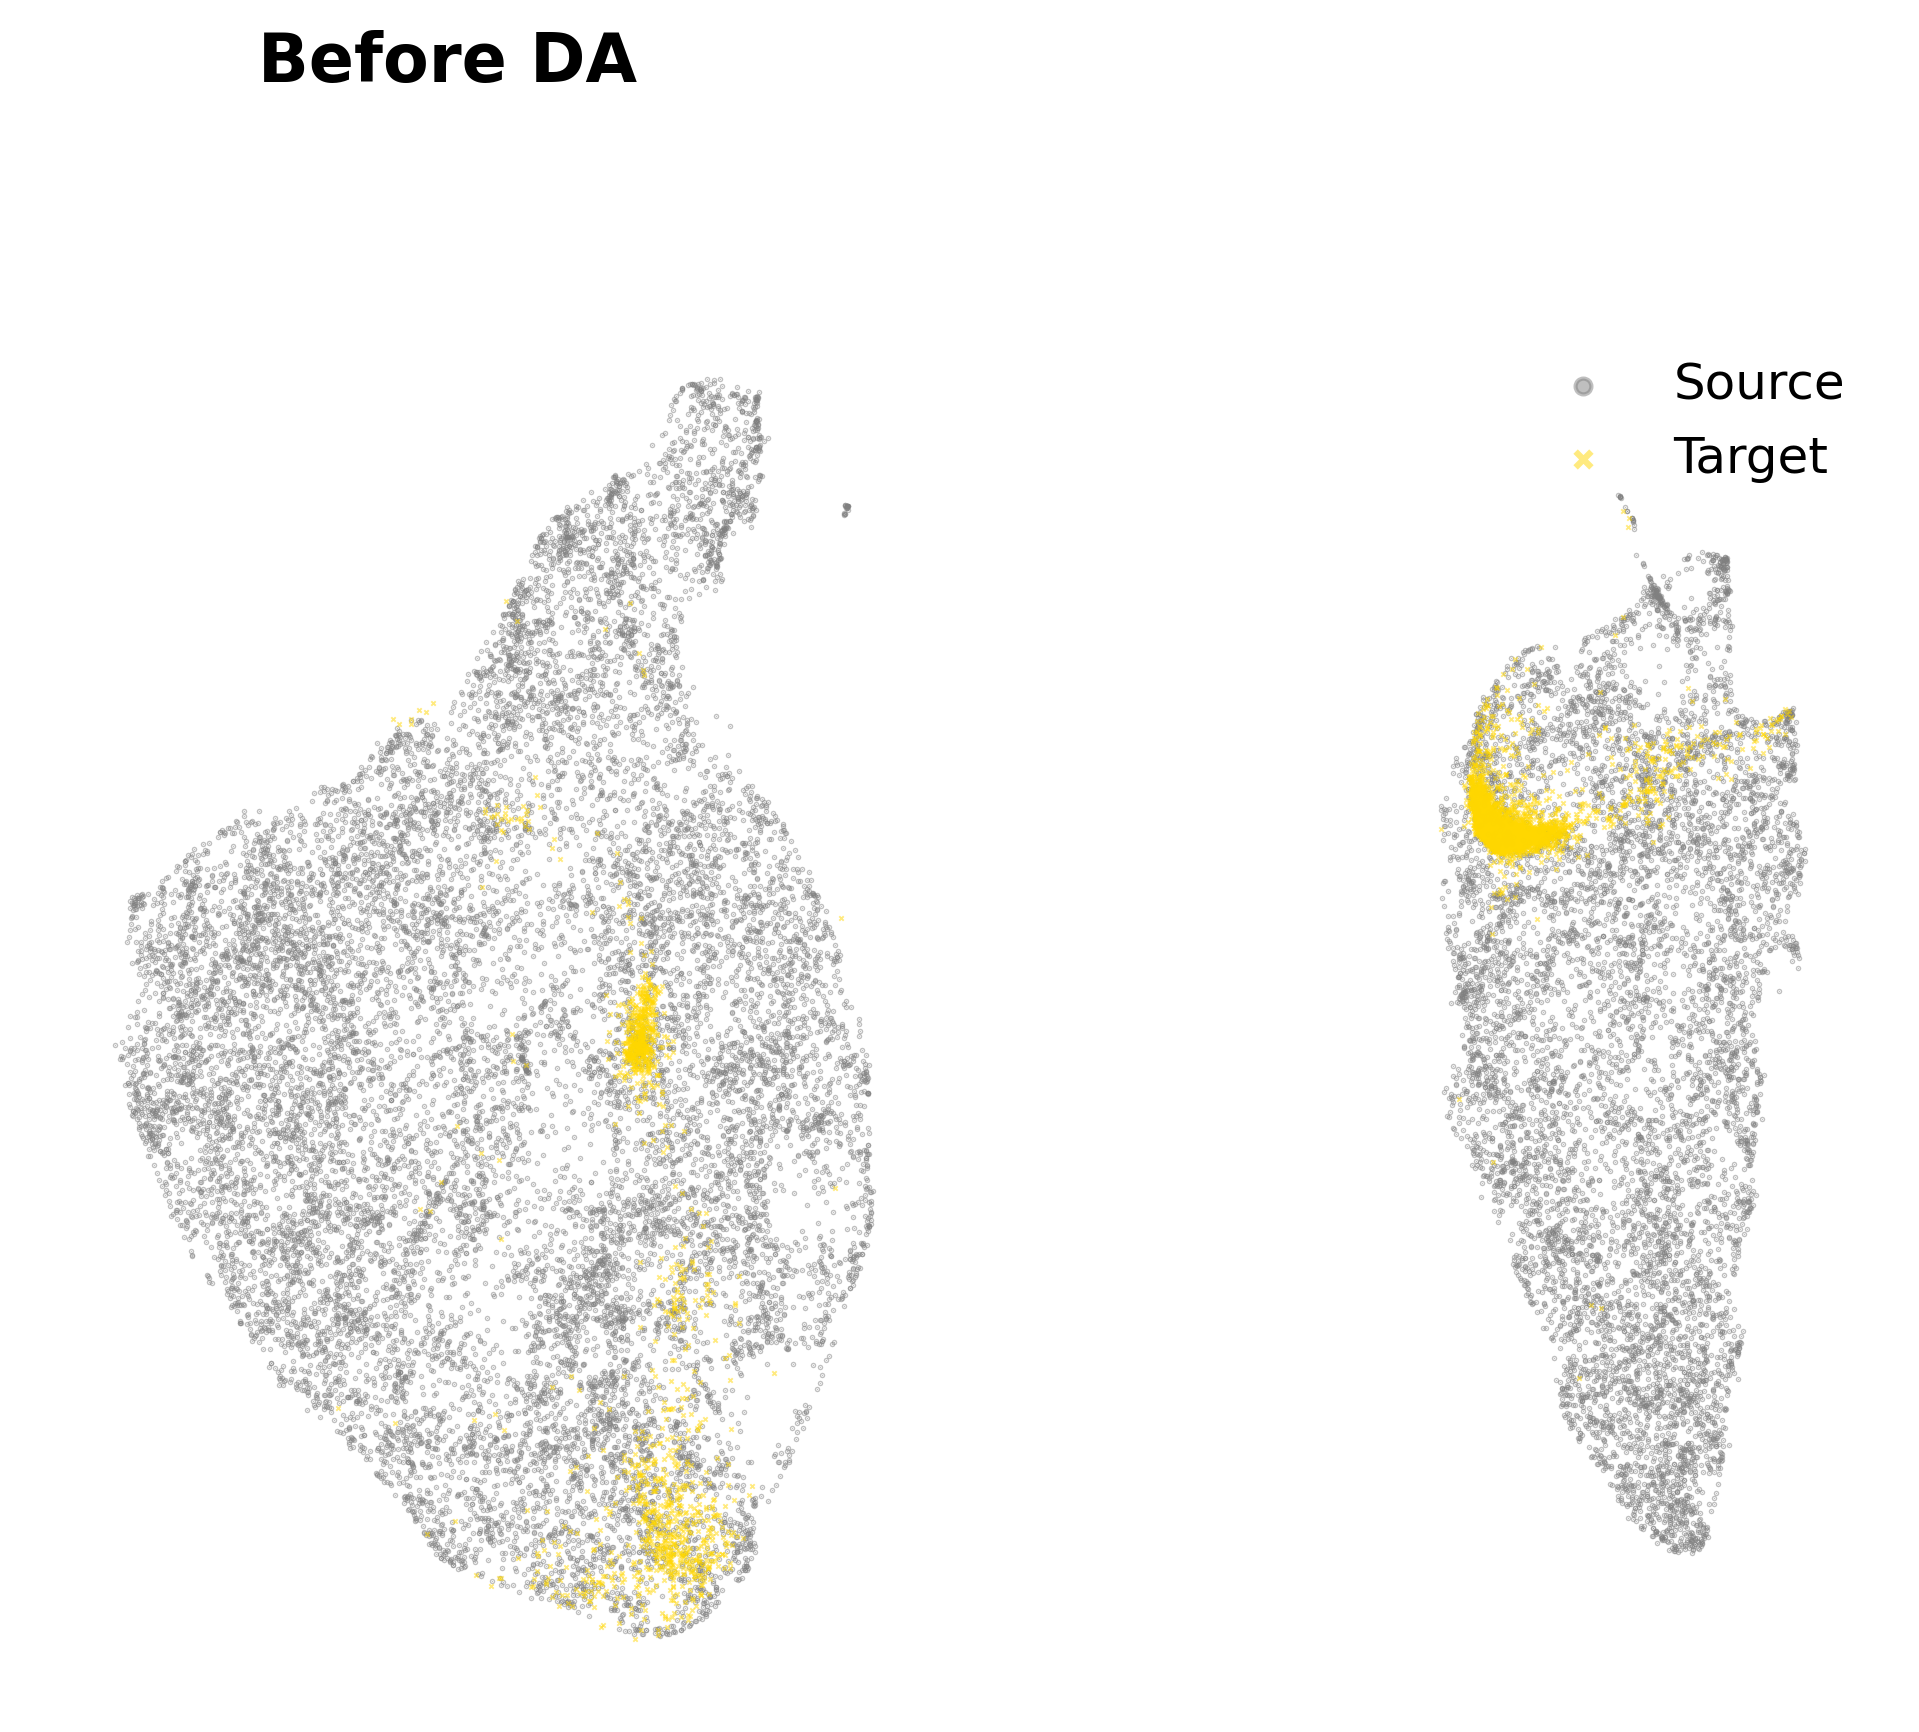

In [32]:
# plot
plt.figure(figsize=(8,6), dpi=300)
plt.scatter(source_tsne[:,0], source_tsne[:,1], color='gray', alpha=0.5, label='Source', s=0.1)
plt.scatter(target_tsne[:,0], target_tsne[:,1], marker='x', color='gold', label='Target', s=0.1, alpha=0.5)

# no ticks and spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.xticks([])
plt.yticks([])

# add text on top left
plt.text(-4, 13, 'Before DA', fontsize=16, weight='bold')

# add legend with scatter size 12 for the markers
plt.legend(markerscale=12, fontsize=12, frameon=False, loc='upper right')

In [17]:
umap_model_final = umap.UMAP(n_neighbors=15,
                        n_components=2,
                        metric='euclidean',
                        min_dist=0.1,
                        random_state=42)

# initial run
umap_model_final.fit(source_features_final)

source_tsne = umap_model_final.transform(source_features_final)
target_tsne = umap_model_final.transform(target_features_final)

/Users/ng27753/Astronomy_Research/haloflow/venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/ng27753/Astronomy_Research/haloflow/venv/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/ng27753/Astronomy_Research/haloflow/venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/ng27753/Astronomy_Research/haloflow/venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


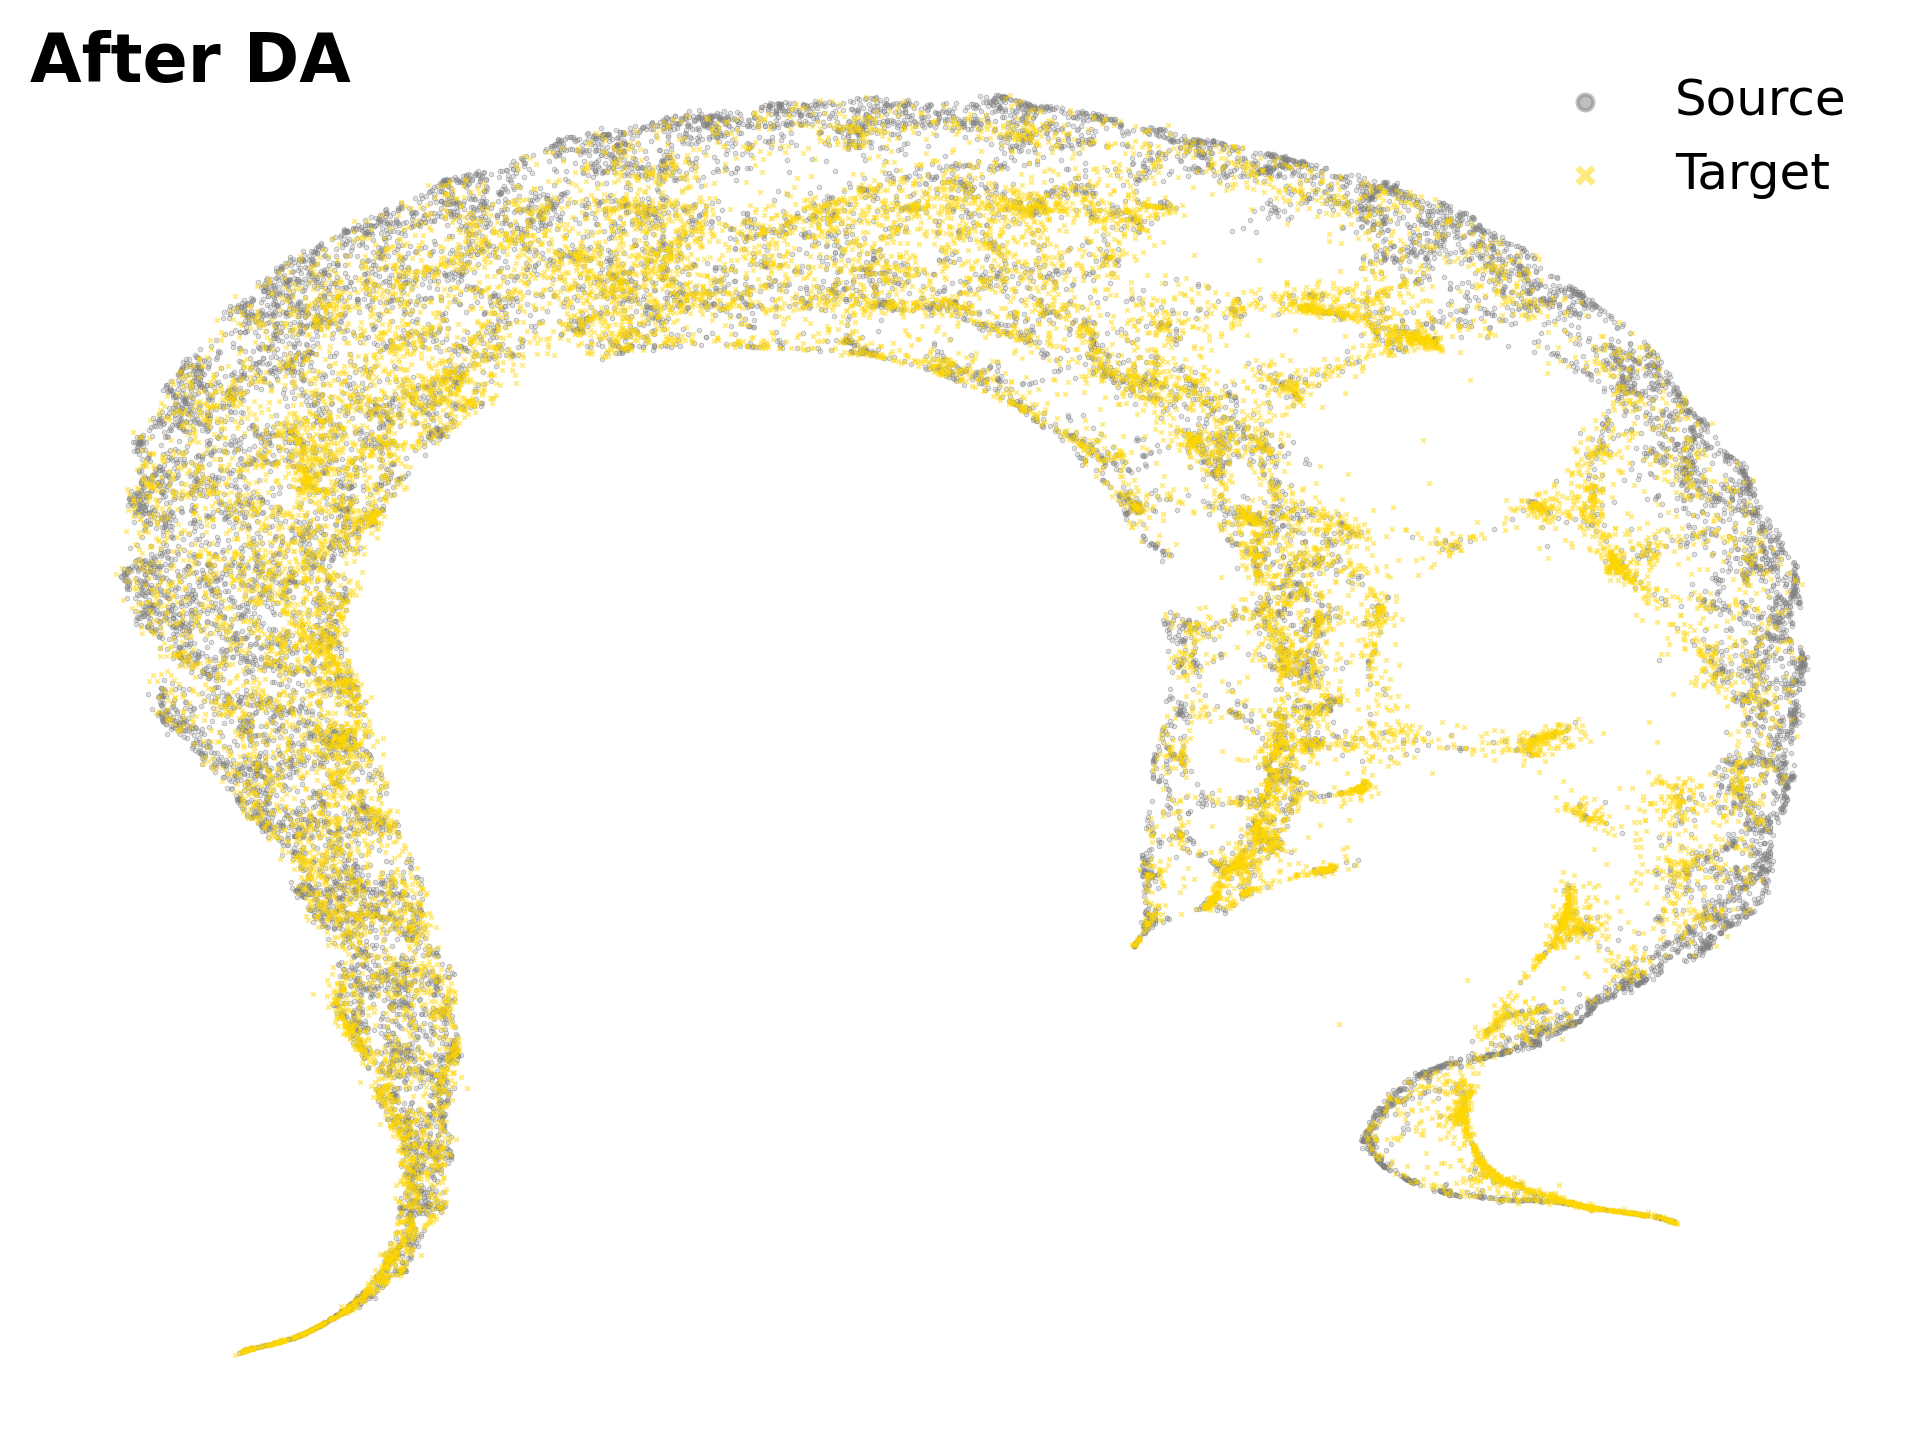

In [18]:
# plot
plt.figure(figsize=(8,6), dpi=300)
plt.scatter(source_tsne[:,0], source_tsne[:,1], color='gray', alpha=0.5, label='Source', s=0.1)
plt.scatter(target_tsne[:,0], target_tsne[:,1], marker='x', color='gold', label='Target', s=0.1, alpha=0.5)

# no ticks and spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.xticks([])
plt.yticks([])

# add text on top left
plt.text(-4, 17, 'After DA', fontsize=16, weight='bold')

# add legend with scatter size 12 for the markers
plt.legend(markerscale=12, fontsize=12, frameon=False)